<a href="https://colab.research.google.com/github/snoop2head/dacon-stock-prediction/blob/main/private_LB_10%EC%9C%84_%EB%B6%88%ED%83%80%EB%8A%94_%EC%8A%A4%EB%88%84%ED%94%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 불타는 스누피 팀
- 김상회 | [@sangHoeKim](https://github.com/sangHoeKim) 
| why750@yonsei.ac.kr | 연세대 산업공학과
- 안영진 | [@snoop2head](https://github.com/snoop2head) | young_ahn@yonsei.ac.kr | 연세대 경제학과

### Final Prediction

<center><img width="550" src="https://github.com/snoop2head/elastic-stock-prediction/blob/main/assets/images/README/output_3x3_december_background.png?raw=true" align="center"/></center>


In [ ]:
def mape(true_df, pred_df):
    """ grading criteria for leader board """
    return (abs(true_df - pred_df) / true_df * 100).iloc[:5].values.mean()

### NMAE Performance in November

Below is Baseline code's performance in November.

| NMAE | 11-01 ~ 11-05 | 11-08 ~ 11-12 | 11-15 ~ 11-19 | 11-22 ~ 11-26 |
| --- | --- | --- | --- | --- |
| **Baseline Linear Regression** | 3.47 | 4.29 | 3.98 | 4.13 |


**Below is the Team's models' performancess in November.**

| NMAE | 11-01 ~ 11-05 | 11-08 ~ 11-12 | 11-15 ~ 11-19 | 11-22 ~ 11-26 |
| --- | --- | --- | --- | --- |
| **ElasticNetCV** | 3.070 | 3.68 | 3.38 | 3.58 |
| **Linear Regression(차분)** | 3.150 | 3.75 | 3.62 | 3.74 |
| **MLP** | 3.00 | 3.61 | 3.39 | 3.44 |
| **ARIMA[0,1,1]** | 3.090 | 3.54 | 3.45 | 3.49 |


## ElasticNetCV

In [ ]:
# get dataset and fonts
!git clone https://github.com/snoop2head/elastic-stock-prediction.git

Cloning into 'elastic-stock-prediction'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 123 (delta 39), reused 107 (delta 28), pack-reused 0
Receiving objects: 100% (123/123), 7.71 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
# Finance Datareader
!pip install -U finance-datareader

# TA-Lib for technical analysis
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3817    0  3817    0     0   8261      0 --:--:-- --:--:-- --:--:--  8261
100  503k  100  503k    0     0   446k      0  0:00:01  0:00:01 --:--:-- 1112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3817    0  3817    0     0  22720      0 --:--:-- --:--:-- --:--:-- 22720
100  406k  100  406k    0     0   494k      0 --:--:-- --:--:-- --:--:--  808k


In [ ]:
# import python modules
import os
import copy

# import data wrangling modules
import pandas as pd
import numpy as np

# import visualization modules
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# import dataloader & stock data downloader
import FinanceDataReader as fdr

# import machine learning modules
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# import machine learning models
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from xgboost import XGBRegressor

# import cell output cleaner
from IPython.display import clear_output

# import stock data derivatives module
from talib import RSI, BBANDS, MACD, ATR

In [ ]:
import warnings
warnings.filterwarnings('ignore') # remove warnings from pandas

# set options pandas: display more columns and reduced digits of float numbers
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
path = '/content/elastic-stock-prediction/data'
list_name = 'stock_list_private.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
display(stock_list.head())
display(stock_list.tail())

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


,종목명,종목코드,상장시장
364,맘스터치,220630,KOSDAQ
365,다날,064260,KOSDAQ
366,제이시스메디칼,287410,KOSDAQ
367,크리스에프앤씨,110790,KOSDAQ
368,쎄트렉아이,099320,KOSDAQ


In [ ]:
# define dates
""" Make dataset for training & evaluation """
from datetime import datetime
import os

# set data window range
start_date = None
data_start_date = None
today = datetime.now()
data_end_date = today.strftime('%Y-%m-%d')

recent_known_date = '2021-11-26'

private_start_4th = '2021-11-29'
private_end_4th = '2021-12-03'

In [ ]:
sample_name = '1129-1203.csv' # last submission
pred_df = pd.read_csv(os.path.join(path,sample_name)).set_index('Day')
pred_df

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def makeData(data):
    """ 
    - make derivative data from the fdr dataset 
    - not using external dataset which increases noise that harms the performance
    """
    
    data = data.copy()
    
    # Korean won volume
    data['KRW_Vol'] = data[['Close', 'Volume']].prod(axis=1)
    data['KRW_Vol_1m'] = data.KRW_Vol.rolling(21).mean()

    # RSI
    data['RSI'] = RSI(data.Close)

    # Bollinger Bands
    def compute_bb(close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

    data[['bb_high', 'bb_low']] = compute_bb(data.Close)
    data['bb_high'] = data.bb_high.sub(data.Close).div(data.bb_high).apply(np.log1p)
    data['bb_low'] = data.Close.sub(data.bb_low).div(data.Close).apply(np.log1p)

    # ATR
    def compute_atr(stock_data):
        df = ATR(stock_data.High, stock_data.Low, 
                 stock_data.Close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())

    data['ATR'] = compute_atr(data)

    #MACD
    def compute_macd(close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)

    data['MACD'] = compute_macd(data.Close)

    # Lagged Returns
    lags = [1, 2, 3, 4, 5, 10, 21, 42, 63]
    for lag in lags:
        data[f'return_{lag}d'] = data.Close.pct_change(lag).add(1).pow(1 / lag).sub(1)

    for t in [1, 2, 3, 4, 5]:
        for lag in [1, 5, 10, 21]:
            data[f'return_{lag}d_lag{t}'] = data[f'return_{lag}d'].shift(t * lag)

    # target return
    for t in [1, 2, 3, 4, 5]:
        data[f'target_{t}d'] = data[f'return_{t}d'].shift(-t)

    # volume change
    q = 0.01
    data[data.filter(like='Vol').columns] = data.filter(like='Vol').pct_change().apply(lambda x: x.clip(lower=x.quantile(q),upper=x.quantile(1 - q)))

    data = data.drop(['Date', 'Open', 'High', 'Low', 'Close'], axis= 1)
    data = data.fillna(method="ffill")
    data = data.fillna(method="bfill")

    return data

In [ ]:
def sklearn_predict(
    pred_df_input, 
    model, 
    start_date,
    recent_known_date,
    clip=True, 
    scaler=RobustScaler()
    ):
    """ make prediction dataframe """

    pred_df_input = pred_df_input.iloc[:5]
    
    for company_code in tqdm(pred_df_input.columns):
        data_raw = fdr.DataReader(
            company_code, 
            start = start_date, 
            end = recent_known_date
            ).reset_index()
        data_raw = data_raw.drop(columns = 'Change')
        data_raw = data_raw.replace(0, np.nan).ffill()
        data_raw.index = data_raw.Date

        # make necessary data for the prediction
        data = makeData(data_raw)
        
        # get the last date of the public submission period
        public_last_close = data_raw.loc[recent_known_date].Close
        public = data.loc[[recent_known_date]]

        # loc[] is inclusive for the end slicing date, unlike list slicing
        train_indv_comp = data.loc[:recent_known_date]
        Ys = train_indv_comp.filter(like='target')
        X = train_indv_comp.drop(Ys.columns, axis=1)    
        Ys_public = public.filter(like='target')
        X_public = public.drop(Ys_public.columns, axis=1)    
        X = scaler.fit_transform(X)
        X_public = scaler.transform(X_public)
        pred_public = []
        public_close = public_last_close
        for y_col in Ys.columns:
            model.fit(X, Ys[y_col])
            r_pred_public = model.predict(X_public)

            public_close = public_close * (1+r_pred_public[0])

            pred_public.append(public_close)
        pred_df_input.loc[:,company_code] = pred_public
        
    return pred_df_input

### Check the performance for sampled 20 companies

In [ ]:
# Utilizing ElasticnetCV to automatically tune the alpha hyperparameter with cross validation. 
# (rho is left at default value 0.5)

PRED_NUM = 20 # random sample 20 companies

if PRED_NUM != None:
    pred_df_sampled = pred_df.copy()
    pred_df_sampled = pred_df_sampled.sample(PRED_NUM, axis=1, random_state=616)

scaler = StandardScaler()
model = ElasticNetCV(max_iter=1000000) # K-Fold is 5 folds

df_result_sampled = sklearn_predict(
    pred_df_input = pred_df_sampled, 
    model = model,
    start_date=data_start_date, 
    recent_known_date = recent_known_date,
    clip=True, 
    scaler=scaler
    )

100%|██████████| 20/20 [05:01<00:00, 15.08s/it]


In [ ]:
df_result_sampled_copy = df_result_sampled.copy()
df_result_sampled_copy

,088350,204320,036930,058820,267980,032640,000990,020150,214980,036540,293780,021240,323990,226950,042000,183300,060250,066570,036460,074600
Day,,,,,,,,,,,,,,,,,,,,
2021-11-29,3069.5230,57634.2538,16711.5220,3427.8786,68209.5471,13806.9846,72962.8400,137577.2622,103287.1176,6639.1673,36276.2645,72683.0374,55785.0676,41652.1540,25055.8461,71233.0575,35338.0340,122052.2733,37010.2710,27416.9718
2021-11-30,3068.7298,57657.0977,16716.8726,3425.8543,68201.1394,13811.6203,73011.2604,138168.8183,103288.6640,6640.8493,36336.5862,72665.6625,55652.5437,41683.9287,25052.7025,71318.9998,35369.0086,122040.7498,37015.8463,27459.8801
2021-12-01,3067.8407,57675.6322,16720.0254,3424.9122,68191.0626,13815.3360,73050.9857,138716.6231,103290.5991,6642.4663,36388.1527,72674.4230,55348.8705,41711.3106,25047.3320,71398.9478,35396.6217,122035.3548,37020.0239,27507.1907
2021-12-02,3066.9136,57691.3531,16722.1171,3426.0799,68180.2721,13818.5345,73087.2754,139244.0215,103293.3635,6642.6879,36425.3355,72693.3338,54967.7196,41736.8473,25039.5115,71478.6271,35422.4709,121948.5849,37023.7105,27560.3514
2021-12-03,3065.9736,57708.4073,16723.5195,3427.1236,68168.8901,13821.3125,73121.7432,139740.8353,103296.8292,6639.4753,36467.7801,72711.6113,54611.3640,41763.3067,25031.4783,71562.5527,35446.9893,121851.0218,37026.9207,27606.4124


In [ ]:
# predict for all companies
PRED_NUM = None

scaler = StandardScaler()
model = ElasticNetCV(max_iter=1000000) # default K-Fold is 5 folds

df_result_all = sklearn_predict(
    pred_df, 
    model,
    start_date=data_start_date, 
    recent_known_date = recent_known_date,
    clip=True, 
    scaler=scaler
    )

In [ ]:
# save as CSV format
name = f"test_{private_start_4th}_{private_end_4th}"
df_result_all.to_csv(f'predict/{name}.csv')

### Visualize Results

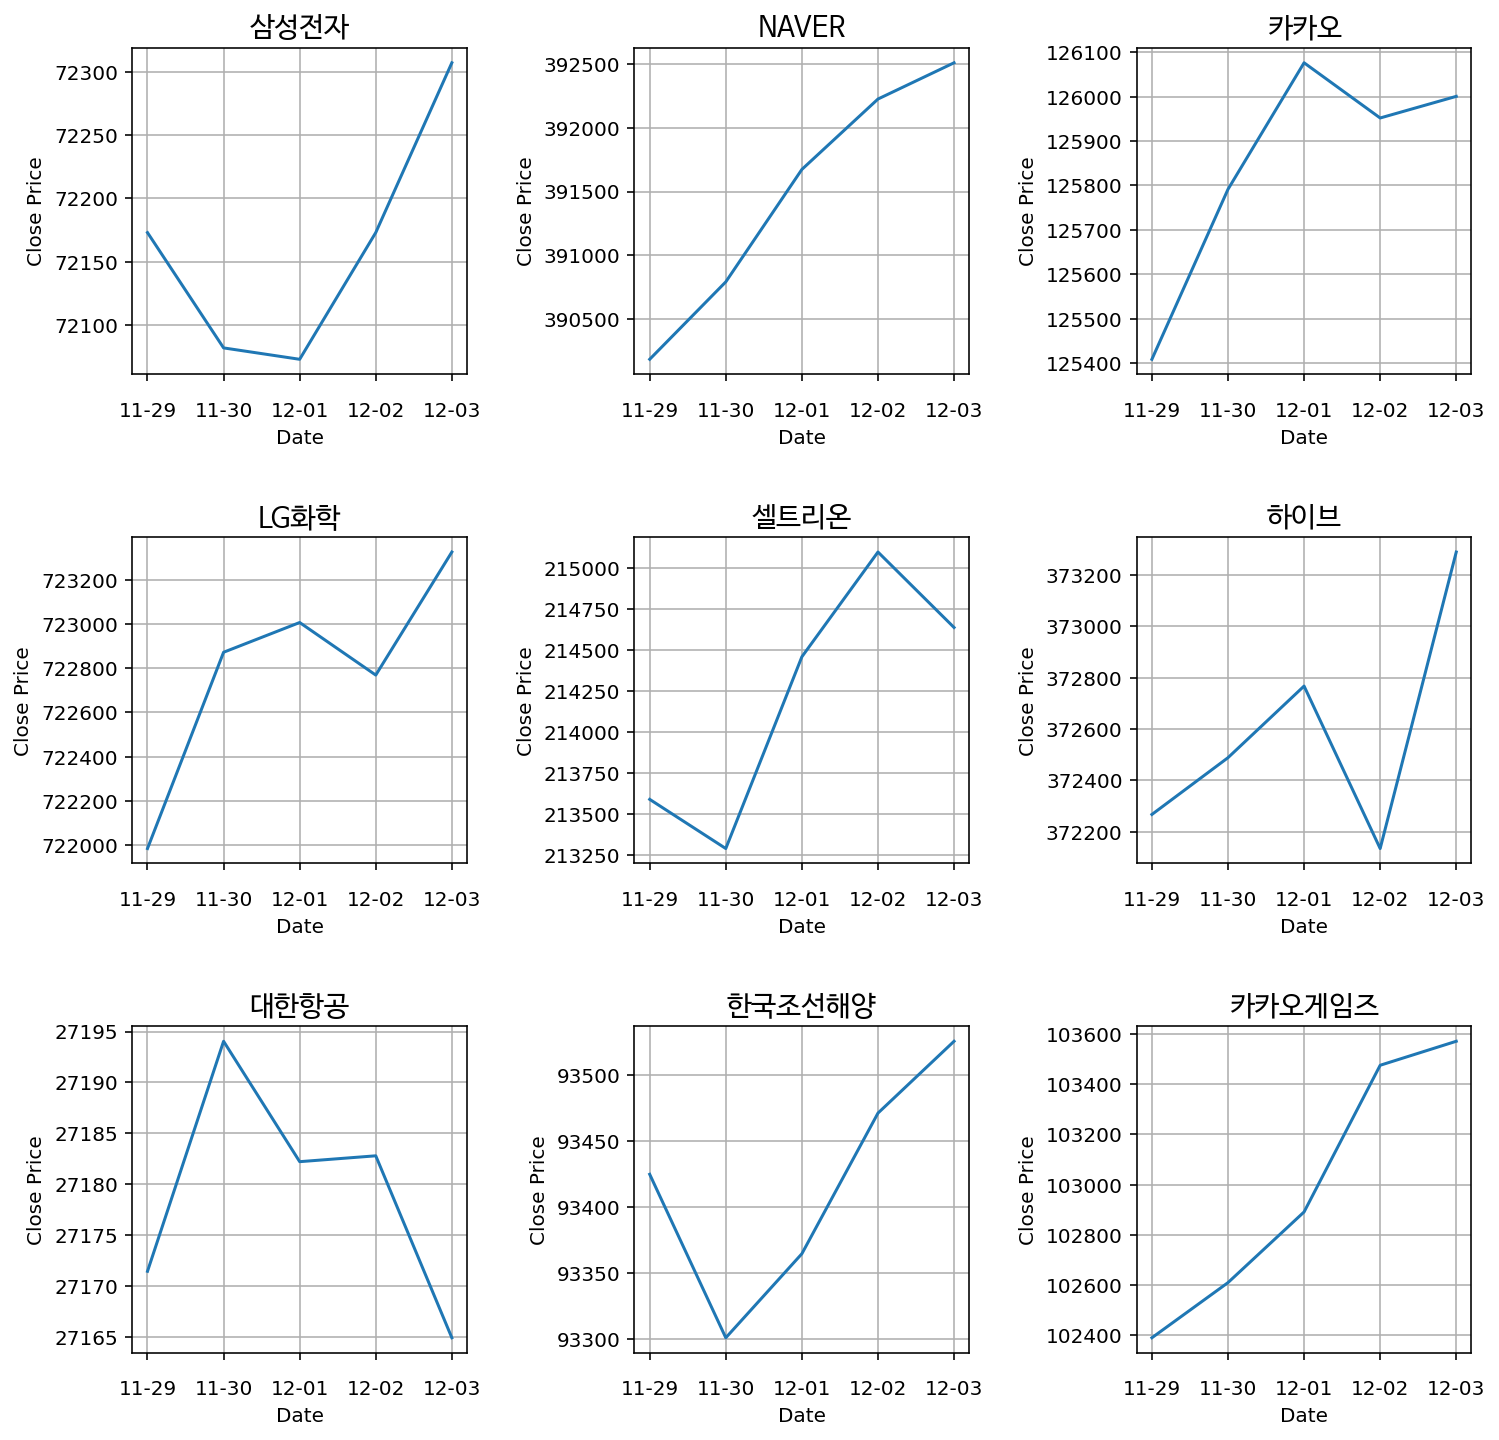

In [ ]:
# Korean font path designation
import matplotlib.font_manager as fm
fontpath = './elastic-stock-prediction/font/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=14)

path = "/content/elastic-stock-prediction/predict/ensembled_MLP 20_private_100_test_2021-11-29_2021-12-03_LR 14_private_100_arima_2021-11-29_2021-12-03.csv"
df_result_ensembled = pd.read_csv(path)[5:]
df_result_ensembled.set_index('Day', inplace=True)
df_result_ensembled.index = df_result_ensembled.index.str.replace('2021-', '') # remove "2021-" from df_result_ensembled.index

# apply retina display for clearer visualization
%config InlineBackend.figure_format = 'retina'

# sample 9 companies from stock_list
# find matching rows based on company_code
sampled_title = ["카카오게임즈", "카카오", "NAVER", "LG화학", "한국조선해양", "셀트리온", "대한항공", "하이브", "삼성전자"]
# get stock codes from stock_list with matching title
sampled_code = stock_list.loc[stock_list['종목명'].isin(sampled_title), '종목코드'].values

# fix tick interval as 10
plt.rcParams['xtick.major.pad'] = 10

# visualize 16 companies subplots from df_result_ensembled
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
# make margin between figures
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# visualize df_result_ensembled 
for i, code in enumerate(sampled_code):
    ax[i//3, i%3].plot(df_result_ensembled.loc[:,code])
    
    # find the matching row of sampled_data from code
    company_name = stock_list[stock_list["종목코드"] == code]["종목명"].values[0]
    ax[i//3, i%3].set_title(company_name, fontproperties=font)
    # remove "2021-" from xlabel Date
    ax[i//3, i%3].set_xlabel('Date')
    ax[i//3, i%3].set_ylabel('Close Price')
    ax[i//3, i%3].grid()

## ARIMA

In [ ]:
# import data wrangling & visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# import stock data loader 
import FinanceDataReader as fdr

In [ ]:
# set options for displaying more options & float formatting at pandas 
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
path = '/content/elastic-stock-prediction/data'
list_name = 'stock_list_private.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
display(stock_list.head())
display(stock_list.tail())
print(stock_list["상장시장"].value_counts())

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


,종목명,종목코드,상장시장
364,맘스터치,220630,KOSDAQ
365,다날,064260,KOSDAQ
366,제이시스메디칼,287410,KOSDAQ
367,크리스에프앤씨,110790,KOSDAQ
368,쎄트렉아이,099320,KOSDAQ


KOSPI     185
KOSDAQ    184
Name: 상장시장, dtype: int64


In [ ]:
""" Make dataset for training & evaluation """
from datetime import datetime

# set data window range
# It appears that 369 companies have different history.
# 1) For new companies, bfill() fills up too much useless information.
# 2) According to quantking backtest, year 2021 and thereafter showed heterogeneous trend than other time periods
# Thus startdate should be more or less than a year long

start_date = "2021-01-04" 
today = datetime.now()
today = today.strftime('%Y-%m-%d')

# competition's date window size definition 
last_day_before_prediction = "2021-11-28" # sunday
start_4th = '2021-11-29' # monday
end_4th = '2021-12-03' # friday

In [ ]:
# get business days between start_date and today
start_weekday = pd.to_datetime(start_date).weekday()
end_weekday = pd.to_datetime(today).weekday()
max_weeknum = pd.to_datetime(today).strftime("%V")
business_days_index = pd.bdate_range(start_date, today)
df_all_business_days = pd.DataFrame(business_days_index, columns=["Date"])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "today" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {df_all_business_days.shape}')

# get business days as dataframe
data_all = df_all_business_days.copy() # use copy not to harm the origin data
stock_list["종목코드"].values.sort() # sort the data according to the company code number

for company_code in tqdm(stock_list["종목코드"].values):
  # read individual company's data all the way until the public data's end
  fdr_data = fdr.DataReader(company_code, start=start_date, end=today)["Close"].reset_index()
  # add up(merge) the data to the business dataframe
  data_all = pd.merge(data_all, fdr_data, how="outer", on="Date")

# forward nan values to the next available value 
data_all.fillna(method="ffill", inplace=True) # fill the end of the dataset, or in the middle

# backward nan values to the previous available value
data_all.fillna(method="bfill", inplace=True) # fill the beginnning dataset


WEEKDAY of "start_date" : 0
NUM of WEEKS to "today" : 49
HOW MANY "Business_days" : (242, 1)


100%|██████████| 369/369 [06:51<00:00,  1.12s/it]


In [ ]:
# get business days between start_date and today
start_weekday = pd.to_datetime(start_date).weekday()
end_weekday = pd.to_datetime(today).weekday()
max_weeknum = pd.to_datetime(today).strftime("%V")
business_days_index = pd.bdate_range(start_date, today)
df_all_business_days = pd.DataFrame(business_days_index, columns=["Date"])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "today" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {df_all_business_days.shape}')

WEEKDAY of "start_date" : 0
NUM of WEEKS to "today" : 49
HOW MANY "Business_days" : (242, 1)


In [ ]:
# check the last five days worth of data
data_all.tail(5)

,Date,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,...,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close_x,Close_y,Close
237,2021-12-01,31700.0000,29400.0000,57700.0000,125000.0000,112000.0000,15500.0000,42750.0000,81200.0000,116500.0000,630000.0000,45200.0000,203000.0000,30850.0000,68100.0000,15250.0000,1830.0000,23550.0000,4795.0000,296000.0000,41800.0000,12100.0000,30900.0000,9180.0000,7580.0000,27400.0000,157500.0000,41900.0000,75800.0000,37750.0000,222000.0000,279500.0000,74400.0000,92300.0000,29350.0000,25300.0000,34100.0000,131500.0000,201000.0000,93200.0000,95200.0000,277000.0000,53600.0000,31000.0000,74400.0000,68600.0000,12450.0000,49950.0000,221500.0000,37600.0000,...,2340.0000,86100.0000,27150.0000,39150.0000,127700.0000,53300.0000,67700.0000,42500.0000,100000.0000,14300.0000,38700.0000,108470.0000,341200.0000,12590.0000,143500.0000,141500.0000,7170.0000,6580.0000,31650.0000,13400.0000,96700.0000,32300.0000,47050.0000,21350.0000,294500.0000,534000.0000,622000.0000,19400.0000,49350.0000,51600.0000,49250.0000,114000.0000,32500.0000,12450.0000,2940.0000,44100.0000,17800.0000,53400.0000,95000.0000,5590.0000,48950.0000,48700.0000,98500.0000,36050.0000,18900.0000,46200.0000,352500.0000,264200.0000,23850.0000,18650.0000
238,2021-12-02,32150.0000,29550.0000,60100.0000,129000.0000,110000.0000,16150.0000,43100.0000,81600.0000,120000.0000,639000.0000,47150.0000,203500.0000,31450.0000,68400.0000,15500.0000,1820.0000,23800.0000,4865.0000,301500.0000,43550.0000,12450.0000,31500.0000,9330.0000,7610.0000,27800.0000,149000.0000,42750.0000,76700.0000,40700.0000,234500.0000,286000.0000,75100.0000,94900.0000,30450.0000,26000.0000,34100.0000,130500.0000,205500.0000,95800.0000,98600.0000,281500.0000,54300.0000,31100.0000,75800.0000,69500.0000,12550.0000,51900.0000,228000.0000,39100.0000,...,2270.0000,84500.0000,19050.0000,39400.0000,115800.0000,54800.0000,68900.0000,44200.0000,100500.0000,14500.0000,39050.0000,108540.0000,317500.0000,12785.0000,150500.0000,142500.0000,7540.0000,6880.0000,31900.0000,13565.0000,91500.0000,33500.0000,45400.0000,22800.0000,291500.0000,569000.0000,618000.0000,19950.0000,49700.0000,52700.0000,45500.0000,113000.0000,33700.0000,12500.0000,2955.0000,47200.0000,17900.0000,55000.0000,97000.0000,5590.0000,51900.0000,46250.0000,95100.0000,33800.0000,18650.0000,48550.0000,330000.0000,274700.0000,25200.0000,18050.0000
239,2021-12-03,32700.0000,30600.0000,60300.0000,131000.0000,108500.0000,16400.0000,44900.0000,82500.0000,118000.0000,642000.0000,48300.0000,209000.0000,31750.0000,68800.0000,15650.0000,1865.0000,24200.0000,4880.0000,313500.0000,44400.0000,12900.0000,31750.0000,9480.0000,7700.0000,28500.0000,150000.0000,42500.0000,78900.0000,40750.0000,241000.0000,286000.0000,76500.0000,100000.0000,30500.0000,26550.0000,33850.0000,133000.0000,206000.0000,95500.0000,98700.0000,284000.0000,55300.0000,32200.0000,75600.0000,69200.0000,12850.0000,52700.0000,229000.0000,39650.0000,...,2235.0000,86200.0000,19150.0000,39600.0000,122000.0000,55200.0000,68800.0000,43000.0000,101000.0000,14900.0000,40000.0000,108300.0000,329000.0000,12880.0000,151000.0000,144500.0000,8020.0000,6920.0000,35000.0000,13580.0000,95200.0000,34000.0000,45900.0000,23100.0000,317500.0000,597000.0000,674000.0000,20250.0000,51700.0000,51800.0000,45900.0000,117000.0000,33750.0000,12750.0000,301

In [ ]:
# import ARIMA statistical model
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# import clear_output to resolve jupyter notebook lagging phenomena
from IPython.display import clear_output

In [ ]:
# sort once again, just in case
stock_list['종목코드'].values.sort()

# copy from original dataset: data_copy will be the input of the ARIMA model
data_copy = data_all.copy() 

# set as index, not as columns: ARIMA cannot process Date column
data_copy.index = data_copy["Date"] 
data_copy.drop(["Date"], axis=1, inplace=True)

# columns are the same as company codes
data_copy.columns = stock_list["종목코드"]

# backward fill for not available data(nan)
data_copy.fillna(method="bfill", inplace=True)

In [ ]:
# prevent leakage of the data
train = data_copy.loc[:last_day_before_prediction].copy() 
train.tail(1).index

DatetimeIndex(['2021-11-26'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
""" Make Submission"""

# Pattern might be more important than the value's closeness.
# However current model yields one prediction value, and adds differentials to the other values.
# Thus constant upward trend and downward trend is only reflected
p, d, q = 0, 1, 1 # Moving Average (1) Model with differentials
# p, d, q = 0, 0, 1 # Moving Average (1) Model

# input columns are timeseries series each: unlike regression analysis!
for col in tqdm(train.columns): 
  print(train[col]) # input data with company code, close data following the "Date" DateTime index(not column)
  
  # https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
  model = ARIMA(train[col], order=(p, d, q)) # load model with ARIMA(p, d, q)
  # 1) d = 1 means that there is a constant trend. it can be also d = 2. stock needs to reflect both the upward and downward trend.
  # 2) Not all 376 companies will follow p=0, q=1, d=1 pattern. 
  
  # https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html
  # fit model with trend of constant term.
  model_fit = model.fit(trend="c", full_output=True, disp=True) 
  
  #forecast last 5 days of data
  forecast_data = model_fit.forecast(steps=5) 

  # get the forecasted data: parse the tuple
  pred_arima_y = forecast_data[0].tolist()
  
  # overwrite first 5 days of data = same as public date
  pred_df[col][:5] = pred_arima_y 
  
  # clear the output
  clear_output()

100%|██████████| 369/369 [00:20<00:00, 18.00it/s]


In [ ]:
pred_df

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,31956.7869,30854.2571,59216.4435,129387.1402,120768.8378,15498.5044,44149.6717,80808.9864,115715.5717,645195.7555,46475.7631,206619.3211,31456.5037,72987.8767,15036.9889,1858.3368,24619.3868,5034.2559,291712.8951,44098.3028,12837.2443,30190.0109,9722.4648,7703.2527,27173.6600,159446.5553,42762.4111,80608.7238,39246.3882,219645.5548,285952.3960,79637.9432,95052.7844,30912.3911,26271.6317,36173.1352,138686.8777,204792.3513,94909.4285,96782.7672,271974.6827,53820.2784,34309.8516,72149.1166,66512.5129,12852.2956,53842.5848,227518.3683,38428.0986,713217.3632,...,2322.1720,87087.0369,20353.1490,39738.8261,133217.0089,54976.8840,68314.0554,44131.7329,104504.2348,15186.0927,38980.5377,107984.6547,345857.8495,12655.8302,148786.9394,149886.9471,6209.5374,7216.0613,33014.1149,13430.9882,102672.6897,36278.6259,48961.4456,22320.8500,262047.1180,511828.2142,627237.8528,21376.9060,51516.9202,51294.9576,42353.8683,110421.5941,35574.0804,12943.4342,2956.2991,45396.0446,19133.1013,55256.3458,98302.3588,5651.1094,44536.4217,48688.3791,102191.2286,39369.8091,19793.9288,50405.6922,372603.1283,276313.6327,24987.9196,16815.8303
2021-11-30,32031.8882,30849.9191,59131.4007,129220.4735,121061.5728,15503.1682,43989.4153,80879.9266,115670.6999,645644.4735,46515.2246,206719.7484,31465.4358,73081.0391,15064.2085,1860.3373,24628.8211,5034.0968,292110.3310,44056.2087,12768.6545,30089.7855,9724.7297,7708.0412,27198.1794,159621.7690,42780.7212,80717.2708,39238.2685,219564.3582,285909.6610,79658.2639,95136.5451,30894.5380,26153.4485,36169.4833,138821.4931,204783.8042,94924.3858,96799.8612,271970.4092,53867.3019,34384.4595,72103.3901,66479.6070,12858.9088,53763.0895,226464.9495,38430.0313,713396.8503,...,2321.9476,87057.0686,20420.0294,39739.0398,133570.0003,54976.0292,68309.0012,43910.0106,104425.1749,15184.2276,39047.5546,107976.3177,346513.8324,12654.1155,148857.4522,149401.0027,6218.0994,7212.6425,33012.1641,13428.3642,102913.7154,36292.1601,48847.4798,22303.5722,262491.5624,513097.4450,629263.4938,21334.3846,51408.2578,51327.8636,42507.9167,110301.9360,35364.2482,12958.0293,2943.3931,45417.8395,19103.1312,54566.1749,98063.4457,5652.7839,44498.1738,48656.1142,102410.0321,39354.4245,19652.8447,50378.1965,373524.4104,276249.9575,24975.7092,16795.4730
2021-12-01,32106.9894,30845.5811,59046.3580,129053.8068,121354.3079,15507.8321,43829.1589,80950.8667,115625.8281,646093.1915,46554.6862,206820.1758,31474.3679,73174.2015,15091.4282,1862.3378,24638.2553,5033.9377,292507.7669,44014.1147,12700.0648,29989.5602,9726.9947,7712.8298,27222.6988,159796.9826,42799.0312,80825.8178,39230.1489,219483.1616,285866.9260,79678.5845,95220.3058,30876.6850,26035.2653,36165.8313,138956.1084,204775.2572,94939.3430,96816.9553,271966.1357,53914.3253,34459.0673,72057.6636,66446.7010,12865.5221,53683.5942,225411.5307,38431.9640,713576.3375,...,2321.7232,87027.1002,20486.9097,39739.2534,133922.9918,54975.1745,68303.9470,43688.2884,104346.1151,15182.3624,39114.5715,107967.9808,347169.8153,12652.4009,148927.9650,148915.0582,6226.6614,7209.2237,33010.2134,13425.7403,103154.7410,36305.6943,48733.5140,22286.2944,262936.0069,514366.6758,631289.1348,21291.8633,51299.5954,51360.7695,42661.9651

In [ ]:
# save as CSV format
name = f"ARIMA_{start_4th}_{end_4th}"
pred_df.to_csv(f'elastic-stock-prediction/predict/{name}.csv')

## Linear Regression based on difference

In [ ]:
path = 'elastic-stock-prediction/data'
list_name = 'stock_list_private.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
display(stock_list.head())
display(stock_list.tail())

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


,종목명,종목코드,상장시장
364,맘스터치,220630,KOSDAQ
365,다날,064260,KOSDAQ
366,제이시스메디칼,287410,KOSDAQ
367,크리스에프앤씨,110790,KOSDAQ
368,쎄트렉아이,099320,KOSDAQ


In [ ]:
# define dates
""" Make dataset for training & evaluation """
from datetime import datetime
import os

# determines whether it is public leaderboard period or new_public period
BOOL_PUBLIC_PERIOD = True

# Determines whether to use public way or private way to utilize data
BOOL_PUBLIC = True

# set data window range
start_date = "2020-10-29"
today = datetime.now()
data_end_date = today.strftime('%Y-%m-%d')

# public_start_date = '2021-09-10'
recent_known_date = '2021-11-26'
pred_start_date = '2021-11-29'
pred_end_date = '2021-11-03'

In [ ]:
sample_name = '1129-1203.csv' # last submission
pred_df = pd.read_csv(os.path.join(path,sample_name)).set_index('Day')
pred_df

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
use_num = 14

# model <- LinearRegression
model = LinearRegression()

for company_code in tqdm(pred_df.columns):
    try:
        # make close diff <- use diff to make X and y data
        data_raw = fdr.DataReader(company_code, start = start_date, end= recent_known_date)
        data_raw["close_diff"] = data_raw.Close - data_raw.Close.shift()

        # save last close
        last_close = data_raw.loc[recent_known_date, "Close"]

        # 하위 2%와 상위 2% 삭제
        data_raw["close_diff_clip"] = data_raw["close_diff"].clip(data_raw["close_diff"].quantile(0.02), data_raw["close_diff"].quantile(0.98))

        # make X and y
        data = pd.DataFrame()
        data["x0"] = data_raw.close_diff_clip
        for n in range(1, use_num):
            data[f"x{n}"] = data_raw.close_diff_clip.shift(n)

        for n in range(1,6):
            data[f"y{n}"] = data_raw.close_diff.shift(-n)

        # x public to predict
        X_public = data.filter(like="x", axis=1).iloc[-1]

        # train and predict
        data_dropna = data.dropna()

        predictions = []
        close = last_close
        for n in range(1,6):
            X = data_dropna.filter(like="x", axis=1)
            y_value = data_dropna[f"y{n}"]

            model.fit(X.values, y_value.values)

            prediction = model.predict(np.expand_dims(X_public,0))
            close = close + prediction[0]
            predictions.append(close)

        # input predict to pred_df
        pred_df[company_code] = predictions
    except:
        print(f"{company_code} 실패")
        pred_df[company_code] = 0

 30%|███       | 111/370 [03:05<07:32,  1.75s/it]

031390 실패


100%|██████████| 370/370 [09:19<00:00,  1.51s/it]


In [ ]:
# save as CSV format
name = f"LR_14_test_{pred_start_date}_{pred_end_date}"
pred_df.to_csv(f'elastic-stock-prediction/predict/{name}.csv')

## Multi Layer Perceptron Based on Difference

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
use_num = 20

# model <- MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64), activation='logistic', random_state=616)

for company_code in tqdm(pred_df.columns):
    try:
        # make close diff <- use diff to make X and y data
        data_raw = fdr.DataReader(company_code, start = start_date, end= recent_known_date)
        data_raw["close_diff"] = data_raw.Close - data_raw.Close.shift()

        # save last close
        last_close = data_raw.loc[recent_known_date, "Close"]

        # 하위 2%와 상위 2% 삭제
        data_raw["close_diff_clip"] = data_raw["close_diff"].clip(data_raw["close_diff"].quantile(0.02), data_raw["close_diff"].quantile(0.98))

        # make X and y
        data = pd.DataFrame()
        data["x0"] = data_raw.close_diff_clip
        for n in range(1, use_num):
            data[f"x{n}"] = data_raw.close_diff_clip.shift(n)

        for n in range(1,6):
            data[f"y{n}"] = data_raw.close_diff.shift(-n)

        # x public to predict
        X_public = data.filter(like="x", axis=1).iloc[-1]

        # train and predict
        data_dropna = data.dropna()

        predictions = []
        close = last_close
        for n in range(1,6):
            X = data_dropna.filter(like="x", axis=1)
            y_value = data_dropna[f"y{n}"]

            model.fit(X.values, y_value.values)

            prediction = model.predict(np.expand_dims(X_public,0))
            close = close + prediction[0]
            predictions.append(close)

        # input predict to pred_df
        pred_df[company_code] = predictions
    except:
        print(f"{company_code} 실패")
        pred_df[company_code] = 0

 30%|███       | 111/370 [15:31<31:26,  7.28s/it]

031390 실패


100%|██████████| 370/370 [52:29<00:00,  8.51s/it]


In [ ]:
# save as CSV format
name = f"MLP_20_test_{pred_start_date}_{pred_end_date}"
pred_df.to_csv(f'elastic-stock-prediction/predict/{name}.csv')

In [ ]:
pred_df

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,31813.2750,30962.8037,59279.7167,129482.7746,120511.4725,15499.0772,44306.2872,80611.2533,115484.1616,645011.1182,46443.4848,206481.6566,31331.6326,72910.6663,15044.4333,1853.7971,24579.1257,5011.7018,291995.3006,44128.7900,12881.1974,30299.1815,9727.5063,7705.7419,27211.9159,159008.7025,42961.0674,80490.4192,39299.2590,219480.8903,286510.7907,79213.0446,95013.3531,30908.7750,26404.9950,36262.9068,138500.1977,205483.9028,95182.4110,96802.7469,271981.2366,53586.1244,34212.7746,72299.6284,66681.4403,12782.5557,53905.5642,228489.8655,38442.2652,713008.3369,...,2339.2712,87212.9963,20199.6211,39763.1149,133013.9338,55080.3901,68199.9229,44393.0785,104483.7432,15136.6501,39011.3447,107954.4446,345214.3746,12638.8821,148512.1038,150485.1159,6224.4925,7197.0982,32981.9709,13410.5673,102404.6172,36210.7617,49061.9195,22299.7314,263485.7690,510008.3677,625014.0241,21380.3671,51691.4782,51499.5341,42315.8119,110512.0456,35730.5826,12883.0787,2969.3849,45411.2934,19149.3907,55899.2515,98581.6566,5631.2343,44549.6411,48748.8386,102014.0900,39349.4026,19994.0089,50601.3476,372014.6337,276481.7766,25009.1998,16632.7971
2021-11-30,31824.3699,30961.9920,59290.3419,129463.2271,120522.9117,15510.9994,44314.9551,80611.6480,115468.7469,645023.6120,46429.7514,206494.3188,31344.0120,72918.3472,15057.3463,1835.3863,24558.7108,5024.4338,292003.0267,44139.5962,12889.2469,30298.5831,9710.1445,7719.2235,27225.5360,159010.4005,42955.1214,80504.9196,39281.3111,219480.1057,286491.1040,79200.1844,95001.6530,30892.5084,26409.3421,36271.6889,138504.7152,205483.4132,95181.8409,96802.1607,271964.6571,53572.4685,34221.8778,72299.1554,66694.5423,12762.7083,53904.8903,228473.2484,38426.9967,713017.1087,...,2349.2609,87225.7144,20183.5703,39775.8676,133027.4153,55079.8304,68179.1555,44377.8219,104482.6704,15121.3778,39022.5980,107963.9185,345227.4352,12649.4341,148524.5241,150470.1350,6220.1992,7178.1515,32993.8161,13410.0997,102412.1461,36222.0786,49061.3774,22299.2348,263479.7065,510020.0163,625027.9481,21380.2787,51690.7308,51498.5747,42331.6780,110525.1784,35732.8877,12898.3446,2950.1177,45400.2402,19132.6306,55883.5194,98562.6910,5616.9038,44561.4785,48739.2924,102026.5171,39348.7218,19991.7005,50614.1117,372029.3286,276480.9927,25022.9585,16623.7806
2021-12-01,31837.3046,30946.4212,59273.0223,129443.5889,120532.0904,15522.9426,44323.1028,80616.5871,115478.0628,645036.7537,46440.8861,206505.5606,31358.0959,72930.9999,15071.9255,1847.3553,24572.0682,5036.7116,292009.5078,44151.4122,12871.5534,30309.3339,9702.5847,7729.9311,27239.4115,159021.5753,42950.3450,80516.2847,39293.0391,219459.3128,286471.1003,79186.1824,94986.9579,30893.9748,26389.8456,36284.6188,138514.1969,205493.1173,95184.9764,96810.4284,271976.6935,53583.2946,34224.4374,72309.4591,66706.0802,12760.0661,53915.2588,228461.7718,38439.1166,713025.3248,...,2328.6011,87208.4601,20193.9947,39787.2633,133041.5393,55091.5754,68159.3650,44362.4097,104464.6418,15134.8363,39036.4088,107970.0486,345241.2947,12663.3736,148509.3814,150454.3181,6234.8956,7189.5367,33004.4616,13423.2845,102420.5595,36233.3773,49060.8984,22298.7903,263480.8139,510029.1586,625041.8524,21361.5396,51674.8365,51497.6362,42347.4295

## Ensemble

In [ ]:
# import python modules
import os
import copy

# import data wrangling modules
import pandas as pd
import numpy as np


In [ ]:
# set options pandas 
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# open and read data from provided csv files
stock_list = pd.read_csv('/content/elastic-stock-prediction/data/stock_list_private.csv')
blank_submission = pd.read_csv('/content/elastic-stock-prediction/data/sample_submission_private.csv')

prediction_path = "/content/elastic-stock-prediction/predict/private"

mlp_file_name = "MLP 20_private_100.00.csv"
mlp_predictions = pd.read_csv(os.path.join(prediction_path,mlp_file_name))
mlp_predictions.set_index('Day', inplace=True)

elasticnetcv_file_name = "test_2021-11-29_2021-12-03.csv"
elasticnetcv_predictions = pd.read_csv(os.path.join(prediction_path,elasticnetcv_file_name))
elasticnetcv_predictions.set_index('Day', inplace=True)

lr_file_name = "LR 14_private_100.00.csv"
lr_predictions = pd.read_csv(os.path.join(prediction_path,lr_file_name))
lr_predictions.set_index('Day', inplace=True)

arima_file_name = "arima_2021-11-29_2021-12-03.csv"
arima_predictions = pd.read_csv(os.path.join(prediction_path,arima_file_name))
arima_predictions.set_index('Day', inplace=True)

In [ ]:
# check whether 녹십자셀 data is marked as 0
display(lr_predictions["031390"])
display(arima_predictions["031390"])
display(mlp_predictions["031390"])
display(elasticnetcv_predictions["031390"])

Day
2021-11-29    0
2021-11-30    0
2021-12-01    0
2021-12-02    0
2021-12-03    0
Name: 031390, dtype: int64

Day
2021-11-29    0
2021-11-30    0
2021-12-01    0
2021-12-02    0
2021-12-03    0
Name: 031390, dtype: int64

Day
2021-11-29    0
2021-11-30    0
2021-12-01    0
2021-12-02    0
2021-12-03    0
Name: 031390, dtype: int64

Day
2021-11-29   0.0000
2021-11-30   0.0000
2021-12-01   0.0000
2021-12-02   0.0000
2021-12-03   0.0000
Name: 031390, dtype: float64

### Check the distribution of ElasticNetCV's prediction

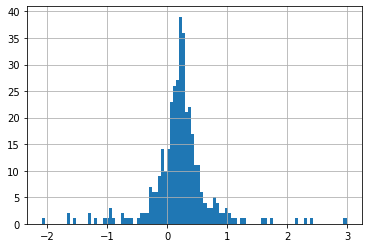

In [ ]:
elasticnetcv_trend = (elasticnetcv_predictions.iloc[-1] - elasticnetcv_predictions.iloc[0]) / elasticnetcv_predictions.iloc[0]
elasticnetcv_trend = elasticnetcv_trend * 100
elasticnetcv_trend.hist(bins=100)

### Check the distribution of ARIMA's prediction

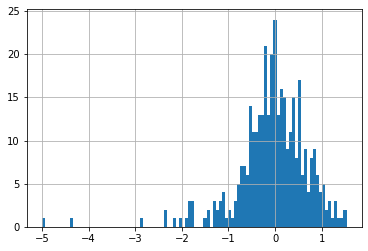

In [ ]:
arima_trend = (arima_predictions.iloc[-1] - arima_predictions.iloc[0]) / arima_predictions.iloc[0]
arima_trend = arima_trend * 100
arima_trend.hist(bins=100)

### Check the distribution of Linear Regression based on Difference

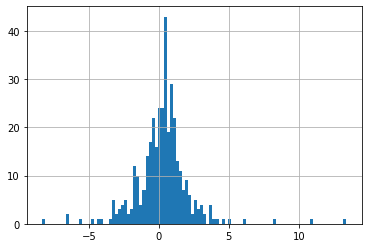

In [ ]:
lr_trend = (lr_predictions.iloc[-1] - lr_predictions.iloc[0]) / lr_predictions.iloc[0]
lr_trend = lr_trend * 100
lr_trend.hist(bins=100)

### Check the distribution of Multi Layer Perceptron's prediction

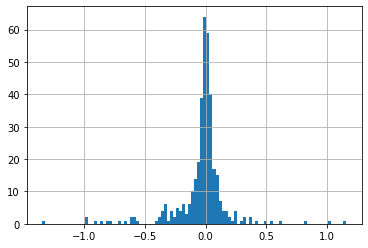

In [ ]:
mlp_trend = (mlp_predictions.iloc[-1] - mlp_predictions.iloc[0]) / mlp_predictions.iloc[0]
mlp_trend = mlp_trend * 100
mlp_trend.hist(bins=100)

### Hardvoting Ensemble

In [ ]:
# change the index as day, remove the column name
blank_submission_without_day = blank_submission.copy()
blank_submission_without_day.index = blank_submission_without_day["Day"]
blank_submission_without_day.drop(["Day"], axis=1, inplace=True)
blank_submission_without_day

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission_copy = blank_submission.copy()

# all values, exclude date column which is the first column

mlp_WEIGHT = 0.25 # NMAE on public leaderboard is 3.075
elasticnetcv_WEIGHT = 0.25 # NMAE on public leaderboard is 3.070
lr_WEIGHT = 0.25 # NMAE on public leaderboard is 3.150
arima_WEIGHT = 0.25 # NMAE on public leaderboard is 3.09

# iterate over columns
for col in blank_submission_without_day.columns:
    # ensemble predictions
    ensemble_val = (
        mlp_WEIGHT * mlp_predictions[col] +                     
        elasticnetcv_WEIGHT * elasticnetcv_predictions[col] +
        lr_WEIGHT * lr_predictions[col] +
        arima_WEIGHT * arima_predictions[col]
    )
    # print(ensemble_val)
    # assign the ensemble predictions to the submission dataframe
    submission_copy[col] = ensemble_val.values
submission_copy

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-29,31902.3031,30951.9001,59271.6896,129540.4824,120031.5715,15534.3870,44171.7924,80818.2987,115281.4150,645294.3489,46480.3718,206209.0233,31327.6586,72828.3251,15066.9332,1853.2867,24583.3804,5020.9112,291582.0654,44114.6717,12862.4155,30301.6629,9740.4820,7709.4054,27171.4194,159355.9152,42989.1214,80706.4519,39228.1087,219565.7220,286432.4623,79863.6258,95135.6517,30900.1595,26369.6960,36201.1562,138532.6636,204835.4271,95082.1589,96769.9312,271760.3190,53660.5794,34226.4137,72172.9717,66496.9472,12816.5279,53904.8476,228076.3607,38450.4858,...,2335.6850,87273.8171,20361.4324,39871.0306,132586.2463,55055.4648,68233.6846,44290.7347,104762.1182,15168.3704,39001.8928,107963.8131,344544.1824,12631.3321,148998.0977,150107.3409,6214.5608,7183.7783,33037.5997,13410.3865,102390.5627,36443.5318,51532.8303,22301.1745,262848.7545,511730.9899,625104.3845,21424.5013,51659.9959,51295.1178,41997.5524,110189.9399,35726.4739,12897.1994,2961.8638,45602.0206,19150.4775,55715.4414,98493.3752,5645.0682,44541.3620,48853.1245,101943.5977,39263.1304,19931.7362,50468.1160,372266.9319,274888.2792,25013.6716,16755.4506
1,2021-11-30,31927.0189,30998.5559,59282.6737,129502.2721,119787.6658,15566.2390,44205.0222,80977.4446,115051.7037,646224.5044,46491.3760,206705.6872,31369.1491,72694.7996,15076.3754,1859.0685,24609.5793,5028.8010,292011.5356,44102.2610,12829.2245,30331.7521,9710.5588,7724.6409,27194.0435,159267.2267,43097.4117,80647.8455,39199.9565,219762.2076,286273.7003,79890.2604,95106.0054,30875.5454,26361.0578,36271.5390,138414.7538,205309.8670,95146.0665,96838.5296,271300.2732,53674.4518,34370.0589,72081.8311,66512.3594,12821.5932,53867.0344,227756.6556,38481.4275,...,2343.0043,87420.5353,20300.3520,39963.2956,132279.6674,55033.5485,68196.6136,44267.7276,104771.6791,15166.3115,39025.1687,107970.2908,344710.9080,12621.0211,149168.8788,149957.3892,6201.6297,7183.6436,33105.1328,13403.4610,102610.1553,36533.8365,51546.6953,22262.8410,262111.0982,510802.3199,623203.4154,21343.5714,51729.9042,51353.7948,42280.2709,110257.6928,35811.5047,12916.3901,2954.4483,45592.5708,19105.3553,55465.3687,98453.9972,5641.5729,44630.3150,48986.5484,102176.6099,39263.5315,19924.8063,50462.6722,372488.2525,274851.6320,25035.9442,16839.4185
2,2021-12-01,32061.0786,31000.0248,59280.5039,129414.4653,120138.9413,15599.1391,44275.5100,81044.6683,115162.8055,646348.2665,46499.6684,207218.0225,31438.6999,72928.0955,15109.2770,1865.9017,24633.3516,5029.9426,292692.5569,44100.7575,12816.3041,30192.6914,9701.3672,7730.6350,27182.2017,159377.2439,43128.8118,80778.7913,39255.7911,219707.5981,285960.7388,79869.2976,95157.7756,30857.9258,26349.4028,36329.6121,138474.4072,205975.3586,95197.2942,96986.3538,271885.0228,53749.4594,34523.5920,72072.8266,66540.8150,12821.6765,53861.8886,227427.9236,38520.6202,...,2335.6546,87474.8486,20229.7526,39973.2893,132310.0687,55092.7195,68244.3484,43986.0629,104750.8273,15188.8520,39153.2853,107997.2935,345103.6360,12633.9884,149304.7833,150049.2416,6198.4366,7191.5129,33144.5043,13418.5093,102891.5728,36893.9992,51612.4443,22271.3169,262219.1200,509776.9473,623377.4109,21339.0550,51348.7422,51512.5931,42483.3365,110318.0543,35745.1790,12925.9347,2953.1714,45616.4674,19103.3030,55381.0133,98277.3330,5640.6268,44671.4134,49108.8409,102568.9047,38980

## Visualize Submission

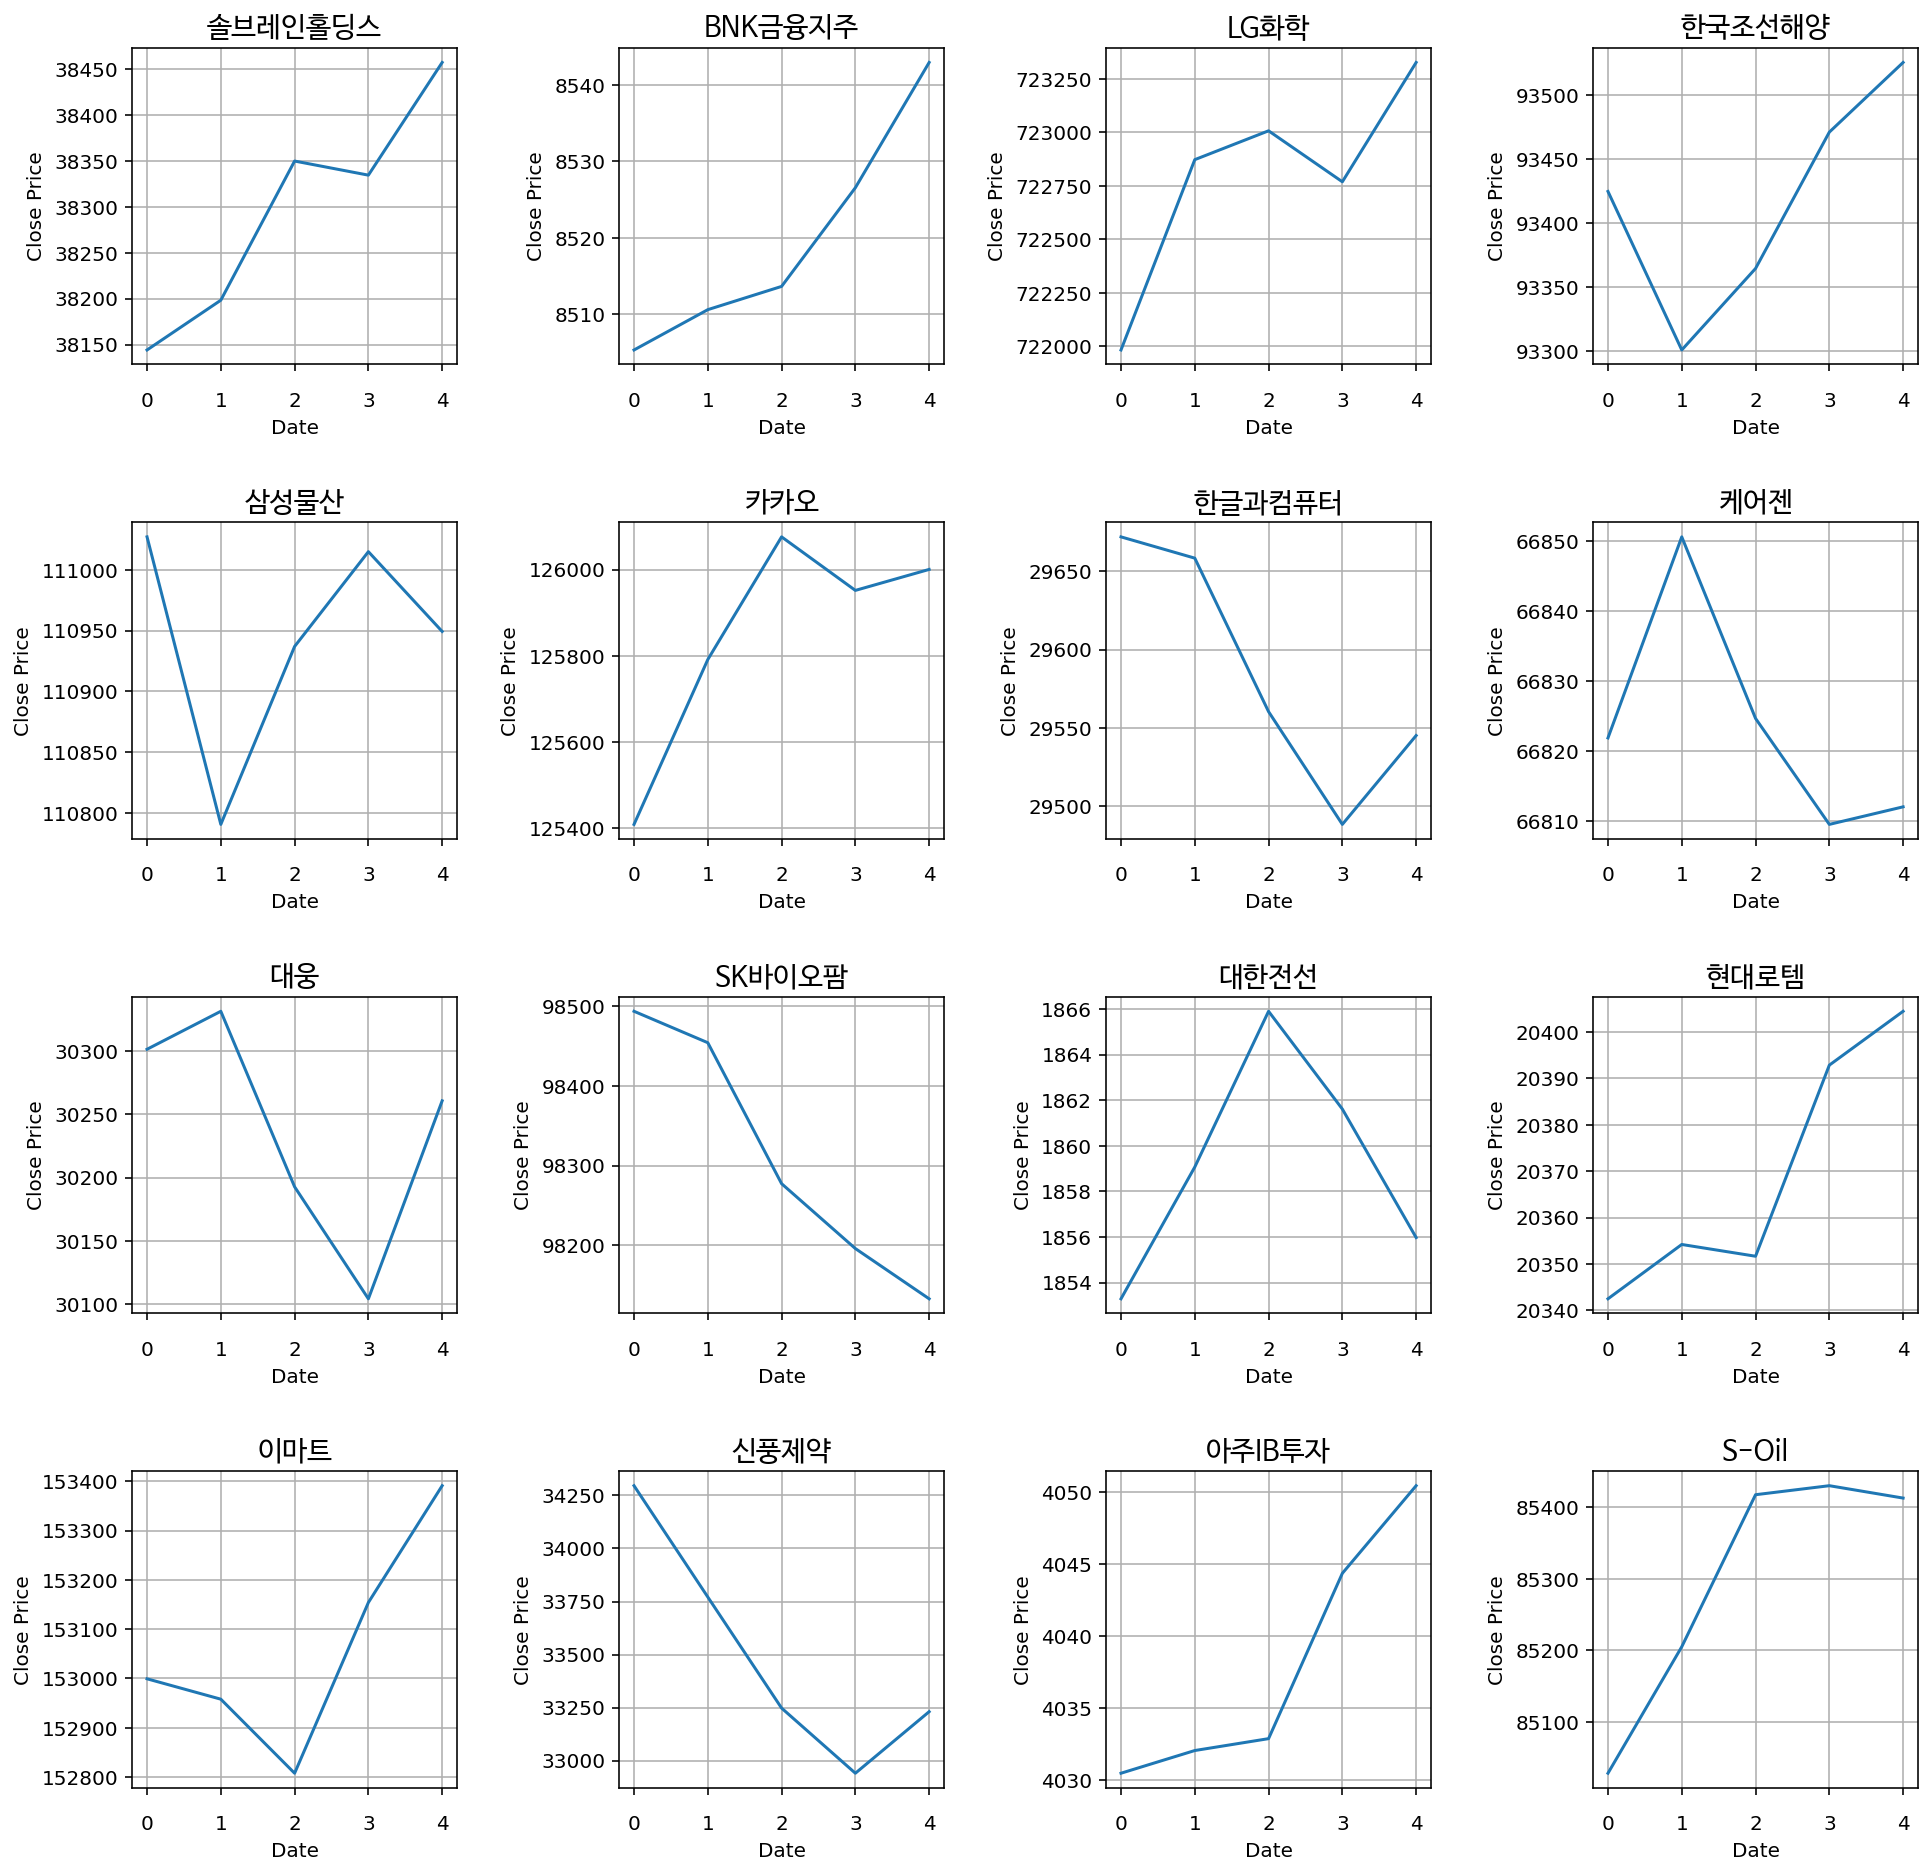

In [ ]:
# apply retina display for clearer visualization
%config InlineBackend.figure_format = 'retina'

# Korean font path designation
import matplotlib.font_manager as fm
fontpath = './elastic-stock-prediction/font/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=14)

# sample 9 companies from stock_list
SAMPLE_NUM = 16
path = './elastic-stock-prediction/data'
list_name = 'stock_list_private.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
sampled_data = stock_list.sample(SAMPLE_NUM)
import matplotlib.pyplot as plt


# fix tick interval as 10
plt.rcParams['xtick.major.pad'] = 10

# visualize 16 companies subplots from df_result_all
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
# make margin between figures
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# visualize df_result_all 
for i, code in enumerate(sampled_data["종목코드"]):
    ax[i//4, i%4].plot(submission_copy.loc[:,code])
    
    # find the matching row of sampled_data from code
    company_name = stock_list[stock_list["종목코드"] == code]["종목명"].values[0]
    ax[i//4, i%4].set_title(company_name, fontproperties=font)
    ax[i//4, i%4].set_xlabel('Date')
    ax[i//4, i%4].set_ylabel('Close Price')
    ax[i//4, i%4].grid()

### Make submission

In [ ]:
# change the index as day, remove the column name
submission_without_day = submission_copy.copy()
submission_without_day.index = submission_without_day["Day"]
submission_without_day.drop(["Day"], axis=1, inplace=True)
submission_without_day

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,005387,005490,005830,005850,005930,005935,005940,006260,006280,006360,006400,...,252670,253450,256840,263720,263750,267250,267980,268600,271560,272210,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-29,31902.3031,30951.9001,59271.6896,129540.4824,120031.5715,15534.3870,44171.7924,80818.2987,115281.4150,645294.3489,46480.3718,206209.0233,31327.6586,72828.3251,15066.9332,1853.2867,24583.3804,5020.9112,291582.0654,44114.6717,12862.4155,30301.6629,9740.4820,7709.4054,27171.4194,159355.9152,42989.1214,80706.4519,39228.1087,219565.7220,286432.4623,79863.6258,95135.6517,30900.1595,26369.6960,36201.1562,138532.6636,204835.4271,95082.1589,96769.9312,271760.3190,53660.5794,34226.4137,72172.9717,66496.9472,12816.5279,53904.8476,228076.3607,38450.4858,713485.3126,...,2335.6850,87273.8171,20361.4324,39871.0306,132586.2463,55055.4648,68233.6846,44290.7347,104762.1182,15168.3704,39001.8928,107963.8131,344544.1824,12631.3321,148998.0977,150107.3409,6214.5608,7183.7783,33037.5997,13410.3865,102390.5627,36443.5318,51532.8303,22301.1745,262848.7545,511730.9899,625104.3845,21424.5013,51659.9959,51295.1178,41997.5524,110189.9399,35726.4739,12897.1994,2961.8638,45602.0206,19150.4775,55715.4414,98493.3752,5645.0682,44541.3620,48853.1245,101943.5977,39263.1304,19931.7362,50468.1160,372266.9319,274888.2792,25013.6716,16755.4506
2021-11-30,31927.0189,30998.5559,59282.6737,129502.2721,119787.6658,15566.2390,44205.0222,80977.4446,115051.7037,646224.5044,46491.3760,206705.6872,31369.1491,72694.7996,15076.3754,1859.0685,24609.5793,5028.8010,292011.5356,44102.2610,12829.2245,30331.7521,9710.5588,7724.6409,27194.0435,159267.2267,43097.4117,80647.8455,39199.9565,219762.2076,286273.7003,79890.2604,95106.0054,30875.5454,26361.0578,36271.5390,138414.7538,205309.8670,95146.0665,96838.5296,271300.2732,53674.4518,34370.0589,72081.8311,66512.3594,12821.5932,53867.0344,227756.6556,38481.4275,713984.6281,...,2343.0043,87420.5353,20300.3520,39963.2956,132279.6674,55033.5485,68196.6136,44267.7276,104771.6791,15166.3115,39025.1687,107970.2908,344710.9080,12621.0211,149168.8788,149957.3892,6201.6297,7183.6436,33105.1328,13403.4610,102610.1553,36533.8365,51546.6953,22262.8410,262111.0982,510802.3199,623203.4154,21343.5714,51729.9042,51353.7948,42280.2709,110257.6928,35811.5047,12916.3901,2954.4483,45592.5708,19105.3553,55465.3687,98453.9972,5641.5729,44630.3150,48986.5484,102176.6099,39263.5315,19924.8063,50462.6722,372488.2525,274851.6320,25035.9442,16839.4185
2021-12-01,32061.0786,31000.0248,59280.5039,129414.4653,120138.9413,15599.1391,44275.5100,81044.6683,115162.8055,646348.2665,46499.6684,207218.0225,31438.6999,72928.0955,15109.2770,1865.9017,24633.3516,5029.9426,292692.5569,44100.7575,12816.3041,30192.6914,9701.3672,7730.6350,27182.2017,159377.2439,43128.8118,80778.7913,39255.7911,219707.5981,285960.7388,79869.2976,95157.7756,30857.9258,26349.4028,36329.6121,138474.4072,205975.3586,95197.2942,96986.3538,271885.0228,53749.4594,34523.5920,72072.8266,66540.8150,12821.6765,53861.8886,227427.9236,38520.6202,714668.7094,...,2335.6546,87474.8486,20229.7526,39973.2893,132310.0687,55092.7195,68244.3484,43986.0629,104750.8273,15188.8520,39153.2853,107997.2935,345103.6360,12633.9884,149304.7833,150049.2416,6198.4366,7191.5129,33144.5043,13418.5093,102891.5728,36893.9992,51612.4443,22271.3169,262219.1200,509776.9473,623377.4109,21339.0550,51348.7422,51512.5931,42483.3365

In [ ]:
# print(true_df.shape, true_df.info())
print(submission_without_day.shape, submission_without_day.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 2021-11-29 to 2021-12-03
Columns: 369 entries, 000060 to 950130
dtypes: float64(369)
memory usage: 14.5+ KB
(5, 369) None


In [ ]:
# remove extension .csv from the file name
mlp_name = mlp_file_name.split(".")[0]
elasticnetcv_name = elasticnetcv_file_name.split(".")[0]
lr_name = lr_file_name.split(".")[0]
arima_name = arima_file_name.split(".")[0]

submission_copy.to_csv(f'./elastic-stock-prediction/predict/private/ensembled_{mlp_name}_{elasticnetcv_name}_{lr_name}_{arima_name}.csv',index=False)